In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/cubicasa5k.zip" -d "/content/cubicasa_dataset"

Streaming output truncated to the last 5000 lines.
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/F1_scaled.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/F1_original.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/model.svg  
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/F1_scaled.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/F1_original.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/model.svg  
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14295/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14295/F2_scaled.png  
  inflating:

In [3]:
!pip install opencv-python matplotlib lxml tqdm pycocotools


In [4]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [5]:
!pip install torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [6]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-0dxd_rah
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0dxd_rah
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.1 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6352509 sha256=68cae8bad88b4b1defb4ba42bbd6b4e2c1146d4bb03635141589d5021d199757
  Stored in directory: /tmp/pip-ephem-wheel-cache-jr4n6tmi/wheels/d3/6e/bd/1969578f1456a6be

In [7]:
import os
import json
from bs4 import BeautifulSoup

import re

translation = {
    "OH": "Living Room",
    "MH": "Bedroom",
    "K": "Kitchen",
    "ET": "Entry",
    "KH": "Bathroom",
    "WC": "Toilet",
    "VH": "Walk-in Closet",
    "TK": "Utility Room",
    "KHH": "Utility Room",
    "PKH": "Dressing Room",
    "KHH/PKH": "Utility / Dressing Room",
    "PH": "Washing Room",
    "RT": "Dining Area",
    "TERASSI": "Terrace",
    "KUISTI": "Porch",
    "TEKN": "Technical Room",
    "TEKN.TILA": "Technical Room",
    "VARASTO": "Storage",
    "VAR": "Storage",
    "VAR/": "Storage",
    "SAUNA": "Sauna",
    "S": "Sauna",
    "AULA": "Lobby",
    "AH": "Living Room/Lounge",
    "TYÖHUONE": "Office",
    "TYÖH/VERSTAT": "Office/Workshop",
    "TYÖ- JA VIERASH": "Office and Guest Room",
    "RUOKAILU": "Dining Area",
    "RUOK": "Dining",
    "RUOK.TILA": "Dining Area",
    "PARVEKE": "Balcony",
    "LASI-PARV": "Glazed Balcony",
    "LASITETTU": "Glazed Balcony/Terrace",
    "LASIKUISTI": "Glazed Porch",
    "ULKOTILA": "Outdoor Space",
    "KORKEA TILA": "High Ceiling Space",
    "KATT.H": "Ceiling Height Room",
    "H": "Generic Room",
    "R": "Generic Room",
    "UNDEFINED": "Unlabeled",
    "PE": "Mirror/Cabinet",
    "PESUH": "Laundry Room",
    "PESU": "Laundry/Washing Room",
    "PSH": "Shower",
    "KK": "Kitchenette",
    "KATOS": "Shelter/Shed",
    "SH": "Shower Room",
    "KEITTIÖ": "Kitchen",
    "AUTOKATOS": "Carport",
    "AUTOTALLI": "Garage",
    "AT": "Garage",
    "LIIKETILA": "Commercial Space",
    "ALKOVI": "Alcove",
    "SpaceForAppliance": "Appliance Space",
    "SpaceForAppliance2": "Appliance Space",
    "APUK": "Auxiliary Kitchen",
    "HARRASTUS": "Hobby Room",
    "HARRASTETILA": "Hobby Space",
    "TH": "Fireplace/Technical Room",
    "RP": "Fireplace",
    "KÄYTÄVÄ": "Corridor",
    "WC/KH": "Toilet/Bathroom",
    "WC/PH": "Toilet/Washing Room",
    "WC-PH": "Toilet-Washing Room",
    "KH/KHH": "Bathroom/Utility Room",
    "KOM": "Closet/Storage",
    "ULLAKKO": "Attic",
    "KYLMÄ VARASTOTILA": "Cold Storage",
    "KYLMÄ VAR.": "Cold Storage",
    "AVOK": "Open Kitchen",
    "PUUPATIO": "Wooden Patio",
    "NURMI PIHAA": "Grass Yard",
    "PSH": "Shower",
    "LÖYLYH": "Steam Room",
    "MEIKKIH": "Makeup Room",
    "KOTITEATTERI": "Home Theater",
    "SISÄVAR": "Indoor Storage",
    "ULKOVAR": "Outdoor Storage",
    "ÖLJY-POLTIN": "Oil Burner",
    "BAARIOS": "Bar Area",
    "AIDATTUA PUUTARHAA": "Fenced Garden",
    "PUUSEPÄN VERSTAS": "Carpenter’s Workshop",
    "TOIMISTOH.": "Office Room",
    "TERASSIPARVEKE": "Terrace Balcony",
    "KATTOTERASSI": "Roof Terrace",
    "MH\\KIRJASTO": "Bedroom/Library",
    "LASIT.PARVEKE": "Glazed Balcony",
    "PARVEKE LASITUS": "Glazed Balcony",
    "LASI PARVEKE": "Glazed Balcony",
    "LAS. PARVEKE": "Glazed Balcony",
    "KPH/": "Bathroom",
    "KPH/WC/KHH": "Bathroom/Toilet/Utility Room",
    "KPH/KHH": "Bathroom/Utility Room",
    "KPH/ASK.H": "Bathroom/Hobby Hall",
    "KPH/ÖLJY": "Bathroom/Fuel Storage",
    "KPH/TAKKA.H": "Bathroom/Fireplace Room",
    "KPH/TKH": "Bathroom/Fireplace Room",
    "KPH/SALI": "Bathroom/Recreation Room",
    "KPH/PARVI": "Bathroom/Loft",
    "KPH/VERANTA": "Bathroom/Porch",
    "KPH/HALLI": "Bathroom/Hall",
    "KPH/PIHA": "Bathroom/Yard",
    "KPH/Undefined": "Bathroom/Unlabeled",
    "KPH/TUPAK": "Bathroom/Fireplace Area",
    "KPH/TALOUS": "Bathroom/Utility",
    "KPH/KOMERO": "Bathroom/Closet",
    "KPH/KUIVAUSH": "Bathroom/Drying Room",
    "KPH/RT/MH": "Bathroom/Dining/Bedroom",
    "KPH/ETEISAULA": "Bathroom/Entry Lobby",
    "KPH/ARKIOLOH": "Bathroom/Living Area",
    "KPH/VIERASHUONE": "Bathroom/Guest Room",
    "KPH/PIHA/TERASSI": "Bathroom/Yard/Terrace",
    "KPH/PATIO": "Bathroom/Patio",
    "KPH/TV-H": "Bathroom/TV Room",
    "KPH/PYÖRÄT": "Bathroom/Bike Storage",
    "KPH/ULKOVARASTO": "Bathroom/Outdoor Storage",
    "KPH/MATALA VAR": "Bathroom/Low Storage",
    "KPH/VAR/TEKN": "Bathroom/Technical Storage",
    "KPH/TEKN+VAR": "Bathroom/Technical Storage",
    "KPH/K/RUOK": "Bathroom/Kitchen/Dining",
    "KPH/K+RT": "Bathroom/Kitchen/Dining Area",
    "KPH/K/RT": "Bathroom/Kitchen/Dining Area",
    "KPH/KATETTU TERASSI": "Bathroom/Glazed Terrace",
    "KPH/LASITETTU PARVEKE": "Bathroom/Glazed Balcony",
    "KPH/LASITETTU TERASSI": "Bathroom/Glazed Terrace",
    "KPH/AVOTERASSI": "Bathroom/Open Terrace",
    "KPH/SISÄPIHA": "Bathroom/Inner Yard",
    "KPH/TERASSIPIHA": "Bathroom/Terrace Yard",
    "KPH/PIHA": "Bathroom/Yard",
    "KPH/PIHA/TERASSI": "Bathroom/Yard/Terrace",
    "KPH/ULKOVAR": "Bathroom/Outdoor Storage",
    "KPH/VAR/KYLMÄ": "Bathroom/Cold Storage",
    "KPH/ALLAS": "Bathroom/Pool",
    "KPH/UIMA-ALLAS": "Bathroom/Swimming Pool",
    "KPH/BAARIOS": "Bathroom/Bar Area",
    "KPH/TV-H": "Bathroom/TV Room",
    "KPH/HISSI": "Bathroom/Elevator",
    "KPH/PYYKKI-H": "Bathroom/Laundry Hall",
    "KPH/PARV.": "Bathroom/Loft",
    "KPH/TUPA": "Bathroom/Cabin",
    "KPH/TUPA/PARVI": "Bathroom/Cabin/Loft",
    "KPH/KELLARI": "Bathroom/Basement",
    "KPH/KELLARI/KYLMÄ ULLAKKO": "Bathroom/Basement/Cold Attic",
    "KPH/KELLARI/TALOUS": "Bathroom/Basement/Utility",
    "KPH/KELLARI/ÖLJY": "Bathroom/Basement/Fuel Storage",
    "KPH/KELLARI/ASK": "Bathroom/Basement/Hobby Room",
    "KPH/KELLARI/HALLI": "Bathroom/Basement/Hall",
    "KPH/KELLARI/KATETTU TERASSI": "Bathroom/Basement/Glazed Terrace",
    "KPH/KELLARI/PUKUH": "Bathroom/Basement/Dressing Room",
    "KPH/KELLARI/PUUVAJA": "Bathroom/Basement/Wood Shed",
    "KPH/KELLARI/POLTTOAIH": "Bathroom/Basement/Fuel Storage",
    "KPH/KELLARI/ASK.H": "Bathroom/Basement/Hobby Hall",
    "KPH/KELLARI/PANNUH": "Bathroom/Basement/Boiler Room",
    "KPH/KELLARI/ÖLJY": "Bathroom/Basement/Fuel Storage",
    "KPH/KELLARI/PUUSEPÄN VERSTAS": "Bathroom/Basement/Workshop",
    "KPH/KELLARI/TOIMISTOH.": "Bathroom/Basement/Office Room",
    "KPH/KELLARI/SALI": "Bathroom/Basement/Recreation Room",
    "KPH/KELLARI/VAR/VH": "Bathroom/Basement/Storage/Dressing",
    "KPH/KELLARI/ARKIOLOH": "Bathroom/Basement/Living Area",
    "KPH/KELLARI/VIERASHUONE": "Bathroom/Basement/Guest Room",
    "KPH/KELLARI/Undefined": "Bathroom/Basement/Unlabeled",
}

# ✅ Normalization function
def normalize_label(label):
    label = label.upper().strip()
    label = re.sub(r"[^\w\s/\\+.-]", "", label)  # Remove stray punctuation
    label = label.replace("\\", "/").replace("+", "/").replace("-", " ")
    parts = re.split(r"[ /]", label)
    # Translate each part using the translation dictionary values
    translated_parts = [translation.get(part, part) for part in parts if part]
    # Normalize the translated parts again to handle cases like "Utility / Dressing Room"
    normalized_translated_parts = [re.sub(r"[^\w\s/\\+.-]", "", part).replace("\\", "/").replace("+", "/").replace("-", " ") for part in translated_parts]
    # Split by space and / and join with /
    final_parts = []
    for part in normalized_translated_parts:
        final_parts.extend(re.split(r"[ /]", part))
    return "/".join([p for p in final_parts if p])


# Create a dictionary of original to normalized labels
translated_labels_dict = {original: normalize_label(original) for original in translation}

# Print the translations
print("Original to Normalized Label Mapping:")
for original, mapped in translated_labels_dict.items():
    print(f"{original} → {mapped}")

# Generate COCO category map from normalized *keys* of the translation dictionary
unique_categories = sorted(set(normalize_label(key) for key in translation.keys()))
category_map = {label: idx + 1 for idx, label in enumerate(unique_categories)} # Start index from 1 for COCO format
category_lookup = {idx + 1: label for idx, label in enumerate(unique_categories)} # Also create a lookup from id to label

print("\nCOCO Category Map:")
for name, cid in category_map.items():
    print(f"{name} → {cid}")


def extract_svg_root(svg_path):
    with open(svg_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f, "xml")
        return soup.find("svg")

def parse_polygon_bbox(polygon):
    points = polygon.get("points", "")
    coords = [tuple(map(float, p.split(","))) for p in points.strip().split()]
    xs, ys = zip(*coords)
    x, y, w, h = min(xs), min(ys), max(xs) - min(xs), max(ys) - min(ys)
    return [x, y, w, h]

def parse_rooms(svg_root):
    rooms = []
    unmapped_labels = set() # Keep track of unmapped labels
    for g in svg_root.find_all("g", class_=lambda c: c and "Space" in c):
        polygon = g.find("polygon")
        if not polygon:
            continue

        label = None
        for sub in g.find_all("g", class_=lambda c: c and "NameLabel" in c):
            text_tag = sub.find("text")
            if text_tag and text_tag.text:
                label = text_tag.text.strip()
                break

        if not label:
            label = g.get("inkscape:label") or g.get("id")
            if label and "room-" in label:
                label = label.split("room-")[-1].strip()

        if not label:
            class_attr = g.get("class", "")
            label = class_attr.split()[-1]

        # Normalize the label using the normalize_label function
        normalized_label = normalize_label(label)

        if normalized_label not in category_map:
            unmapped_labels.add(normalized_label) # Add to unmapped set
            continue # Skip this room if not in category_map for now


        bbox = parse_polygon_bbox(polygon)

        rooms.append({
            "name": normalized_label,
            "bbox": bbox
        })
    if unmapped_labels:
        print(f" Found unmapped labels: {unmapped_labels}") # Print unmapped labels
    return rooms


def generate_annotations(rooms, image_id, category_map, start_id=1):
    annotations = []
    for i, room in enumerate(rooms):
        name = room["name"]
        # Ensure category_id exists in category_map before assigning
        if name in category_map:
            category_id = category_map[name]
            area = room["bbox"][2] * room["bbox"][3]

            annotations.append({
                "id": start_id + i,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": room["bbox"],
                "area": area,
                "iscrowd": 0
            })
    return annotations

def process_svg_folder(folder_path, output_json):
    images = []
    annotations = []
    image_id = 1000
    ann_id = 1

    for filename in os.listdir(folder_path):
        if not filename.endswith(".svg"):
            continue

        svg_path = os.path.join(folder_path, filename)
        svg_root = extract_svg_root(svg_path)
        rooms = parse_rooms(svg_root)

        images.append({
            "id": image_id,
            "file_name": filename,
            "width": 2048,  # optional: set actual width
            "height":2048
        })

        anns = generate_annotations(rooms, image_id, category_map, start_id=ann_id)
        annotations.extend(anns)
        ann_id += len(anns)
        image_id += 1

    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": cid, "name": name} for name, cid in category_map.items()]
    }

    with open(output_json, "w") as f:
        json.dump(coco_data, f, indent=2)
    print(f" Saved {output_json} with {len(images)} images and {len(annotations)} annotations.")

Original to Normalized Label Mapping:
OH → Living/Room
MH → Bedroom
K → Kitchen
ET → Entry
KH → Bathroom
WC → Toilet
VH → Walk/in/Closet
TK → Utility/Room
KHH → Utility/Room
PKH → Dressing/Room
KHH/PKH → Utility/Room/Dressing/Room
PH → Washing/Room
RT → Dining/Area
TERASSI → Terrace
KUISTI → Porch
TEKN → Technical/Room
TEKN.TILA → Technical/Room
VARASTO → Storage
VAR → Storage
VAR/ → Storage
SAUNA → Sauna
S → Sauna
AULA → Lobby
AH → Living/Room/Lounge
TYÖHUONE → Office
TYÖH/VERSTAT → TYÖH/VERSTAT
TYÖ- JA VIERASH → TYÖ/JA/VIERASH
RUOKAILU → Dining/Area
RUOK → Dining
RUOK.TILA → Dining/Area
PARVEKE → Balcony
LASI-PARV → LASI/PARV
LASITETTU → Glazed/Balcony/Terrace
LASIKUISTI → Glazed/Porch
ULKOTILA → Outdoor/Space
KORKEA TILA → KORKEA/TILA
KATT.H → Ceiling/Height/Room
H → Generic/Room
R → Generic/Room
UNDEFINED → Unlabeled
PE → Mirror/Cabinet
PESUH → Laundry/Room
PESU → Laundry/Washing/Room
PSH → Shower
KK → Kitchenette
KATOS → Shelter/Shed
SH → Shower/Room
KEITTIÖ → Kitchen
AUTOKATOS → 

In [8]:
svg_root = extract_svg_root("/content/cubicasa_dataset/cubicasa5k/colorful/10106/model.svg")
rooms = parse_rooms(svg_root)

for room in rooms:
    print(room)

{'name': 'Terrace', 'bbox': [394.41, 1553.54, 347.59999999999997, 341.20000000000005]}
{'name': 'Porch', 'bbox': [1144.01, 936.69, 151.51, 550.19]}
{'name': 'Terrace', 'bbox': [897.15, 181.74, 249.39999999999998, 302.15999999999997]}
{'name': 'Dining/Area', 'bbox': [498.65, 212.96, 361.5, 307.93999999999994]}
{'name': 'Generic/Room', 'bbox': [498.65, 520.9, 610.9, 445.46000000000004]}
{'name': 'Kitchen', 'bbox': [133.66, 212.96, 364.99, 460.43999999999994]}
{'name': 'Entry', 'bbox': [440.65, 965.66, 354.59000000000003, 554.0300000000001]}
{'name': 'Generic/Room', 'bbox': [133.66, 978.66, 351.99, 541.0300000000001]}
{'name': 'Utility/Room/Dressing/Room', 'bbox': [808.24, 979.36, 301.30999999999995, 443.64]}
{'name': 'Generic/Room', 'bbox': [133.66, 686.4, 351.99, 279.26]}
{'name': 'Washing/Room', 'bbox': [873.53, 1436.0, 229.92000000000007, 215.49]}
{'name': 'Toilet', 'bbox': [683.53, 1386.54, 177.0, 226.47000000000003]}
{'name': 'Unlabeled', 'bbox': [918.24, 1664.49, 191.30999999999995

In [9]:
base_dir = "/content/cubicasa_dataset/cubicasa5k"

def load_split_folders(txt_path):
    """Loads folder paths from a .txt file."""
    paths = []
    with open(txt_path, 'r') as f:
        for line in f:
            # Remove leading/trailing whitespace and potential '/'
            cleaned_line = line.strip().strip('/')
            # The paths in the txt are already relative to the base_dir, so just use the cleaned line
            paths.append(cleaned_line)
    return paths

In [10]:
base_dir = "/content/cubicasa_dataset/cubicasa5k" # Use absolute path

def process_split(split_name, folder_paths, output_json):
    images, annotations = [], []
    image_id, ann_id = 1000, 1
    present_categories = set() # Keep track of categories present in this split

    # Ensure category_map is available globally
    if 'category_map' not in globals():
        print("Error: category_map not found. Please run the data processing cell (ZU6U7nelTH2c) first.")
        return


    # Create a category_lookup dictionary for efficient lookup from category_id to name
    category_lookup = {cid: name for name, cid in category_map.items()}


    for relative_path in folder_paths:
        svg_path = os.path.join(base_dir, relative_path, "model.svg")
        png_path = os.path.join(base_dir, relative_path, "F1_scaled.png") # Path to the PNG image

        if not os.path.exists(svg_path):
            print(f"❌ model.svg not found at {svg_path}")
            continue
        if not os.path.exists(png_path): # Check if the corresponding PNG exists
             print(f"❌ F1_scaled.png not found at {png_path}")
             continue

        # Get image dimensions
        try:
            from PIL import Image # Import Image here to avoid potential conflicts or late imports
            with Image.open(png_path) as img:
                width, height = img.size
        except Exception as e:
            print(f"❌ Could not read image size for {png_path}: {e}")
            continue

        # Only process if both files exist and dimensions are read
        svg_root = extract_svg_root(svg_path)
        rooms = parse_rooms(svg_root)

        style = relative_path.split("/")[0]  # e.g., "colorful"
        folder_name = relative_path.split("/")[1]  # e.g., "10052"

        images.append({
           "id": image_id,
           "file_name": png_path, # Store absolute path to the image
           "style": style,
           "width": width,  # Use actual width
           "height": height # Use actual height
         })

        anns = generate_annotations(rooms, image_id, category_map, start_id=ann_id)
        annotations.extend(anns)
        ann_id += len(anns)
        image_id += 1

        # Update present categories based on annotations generated
        for ann in anns:
            # Ensure category_id exists in category_lookup before accessing
            if ann["category_id"] in category_lookup:
                present_categories.add(category_lookup[ann["category_id"]])
            else:
                print(f"⚠️ Category ID {ann['category_id']} not found in category_lookup.")


    # Filter category_map to only include categories present in this split
    # This filtering was causing issues with consistent category IDs across splits.
    # Instead, we will use the comprehensive category_map and only include
    # categories that are actually present in the annotations of this split
    # in the "categories" list of the output JSON.

    # Create the list of category dictionaries for the output JSON,
    # including only categories present in this split but using the
    # global category_map for ID and name.
    filtered_categories_list = [{"id": category_map[name], "name": name}
                                for name in sorted(list(present_categories))]


    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": filtered_categories_list # Use the filtered list of categories
        # Removed the misplaced "category_id" line
    }

    os.makedirs(os.path.dirname(output_json), exist_ok=True)
    with open(output_json, "w") as f:
        json.dump(coco_data, f, indent=2)
    print(f"✅ Saved {split_name} annotations to {output_json}")

In [11]:
from PIL import Image, ImageFile
import os
import json
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Increase Pillow's image size limit to handle large images
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

# Load split folders
train_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/train.txt"))
val_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/val.txt"))
test_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/test.txt"))

# Collect all unique normalized labels from all splits
all_normalized_labels_in_dataset = set()

# Collect all unique room names from all splits to create a comprehensive category map
# This part remains to ensure the category_map is based on the original translation keys as intended.
# The collection of all_normalized_labels_in_dataset is for identifying missing translations.
all_room_names_from_translation_keys = set()
for key in translation.keys():
     all_room_names_from_translation_keys.add(normalize_label(key))


# Process each split to find all unique normalized labels present in the dataset
for split_folders in [train_folders, val_folders, test_folders]:
    for relative_path in split_folders:
        svg_path = os.path.join("/content/cubicasa_dataset/cubicasa5k", relative_path, "model.svg")
        if os.path.exists(svg_path):
            svg_root = extract_svg_root(svg_path)
            for g in svg_root.find_all("g", class_=lambda c: c and "Space" in c):
                label = None
                for sub in g.find_all("g", class_=lambda c: c and "NameLabel" in c):
                    text_tag = sub.find("text")
                    if text_tag and text_tag.text:
                        label = text_tag.text.strip()
                        break

                if not label:
                    label = g.get("inkscape:label") or g.get("id")
                    if label and "room-" in label:
                        label = label.split("room-")[-1].strip()

                if not label:
                    class_attr = g.get("class", "")
                    label = class_attr.split()[-1]

                # Normalize the label and add to the set of all normalized labels in the dataset
                normalized_label = normalize_label(label)
                all_normalized_labels_in_dataset.add(normalized_label)


# Generate COCO category map from normalized *keys* of the translation dictionary (as fixed previously)
# We will use the unique normalized keys from the translation dictionary as the base for the category map.
unique_categories = sorted(list(all_room_names_from_translation_keys))
category_map = {name: idx + 1 for idx, name in enumerate(unique_categories)}
category_lookup = {idx + 1: name for idx, name in enumerate(unique_categories)}


# Print all unique normalized labels found in the dataset to help identify missing ones
print("\nUnique Normalized Labels found in the Dataset:")
for label in sorted(list(all_normalized_labels_in_dataset)):
    print(label)

# Print labels found in the dataset that are not in the category map
unmapped_labels_in_dataset = sorted(list(all_normalized_labels_in_dataset - set(category_map.keys())))
if unmapped_labels_in_dataset:
    print("\nLabels found in dataset but not in category_map (need translation/mapping):")
    for label in unmapped_labels_in_dataset:
        print(label)
else:
    print("\nAll normalized labels found in the dataset are in the category_map.")


# Generate COCO annotations for each split using the comprehensive category map
process_split("train", train_folders, "annotations/train_annotations.json")
process_split("val", val_folders, "annotations/val_annotations.json")
process_split("test", test_folders, "annotations/test_annotations.json")

# Register the datasets with the comprehensive categories and correct image root
# Unregister the datasets if they exist
if "cubicasa_train" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_train")

if "cubicasa_train" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_train")

if "cubicasa_test" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_test")

if "cubicasa_test" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_test")

if "cubicasa_val" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_val")

if "cubicasa_val" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_val")


# Use the comprehensive category map for registration
register_coco_instances("cubicasa_train", {"thing_classes": list(category_map.keys())}, "annotations/train_annotations.json", "/content/")
register_coco_instances("cubicasa_val", {"thing_classes": list(category_map.keys())}, "annotations/val_annotations.json", "/content/")
register_coco_instances("cubicasa_test", {"thing_classes": list(category_map.keys())}, "annotations/test_annotations.json", "/content/")

# Explicitly set the thing_classes after registration (redundant but kept for robustness)
MetadataCatalog.get("cubicasa_train").thing_classes = list(category_map.keys())
MetadataCatalog.get("cubicasa_val").thing_classes = list(category_map.keys())
MetadataCatalog.get("cubicasa_test").thing_classes = list(category_map.keys())


Unique Normalized Labels found in the Dataset:
13557B9A/9511/4AD8/A227/3A2A746D6604
164M2
3F505217/FF3F/4B20/B6C5/2247465C6B7E
40M2
4A28A836/025F/4922/981B/4A76B4B4CC88
576/M2
59173761/5D49/44F1/836B/476454AE4FAB
69B2C526/E277/44C6/9E02/AA44D27F0E5C
7B6AB6DD/2D2D/4BB0/B535/BB1F89ED434B
86B5E9F6/495B/4B9F/B78F/F0892F412979
9130A0A7/7059/445E/B851/23029403843D
A/1
A/2
A6F6001B/6A1F/4F1F/B46C/36B6C57336DE
AIDATTUA/PUUTARHAA
AITTA
AJOLUISKA
AK
ALA/Entry
ALA/Lobby
ALAHALLI
ALAPIHA
ALATERASSI
ALK
ALLAS
ALLASH
ALLASHUONE
ALVKOVI
AP
APK
APK/Dressing/Room
APUKEITTIÖ
APUT
APUTILA
ARKIET
ARKIH
ARKIOH
ARKIOLOH
ARKIS
ARKISTO
ASK
ASK./Generic/Room
ASK.H
ASK.TILA
ASK/Bedroom
ASK/HARR
ASK/JA/KERHOHUONE
ASK/Storage
ASK/Technical/Room
ASUNTOPIHA
ATELJEE
ATKH
AUTO
AUTOHALLI
AUTOPAIKKA
AUTOSUOJA
AUTOVAJA
AUTOVAJA/Storage
AVOIN/ALAS
AVOIN/YLOS
AVOKEITTIÖ
AVOKONTTORI
AVOKUISTI
AVOKUSTI
AVOPARVEKE
AVOPARVI
AVOTERASSI
Alcove
Attic
Attic/Storage
Auxiliary/Kitchen
Auxiliary/Kitchen/Dressing/Room
Auxiliary/Kitc

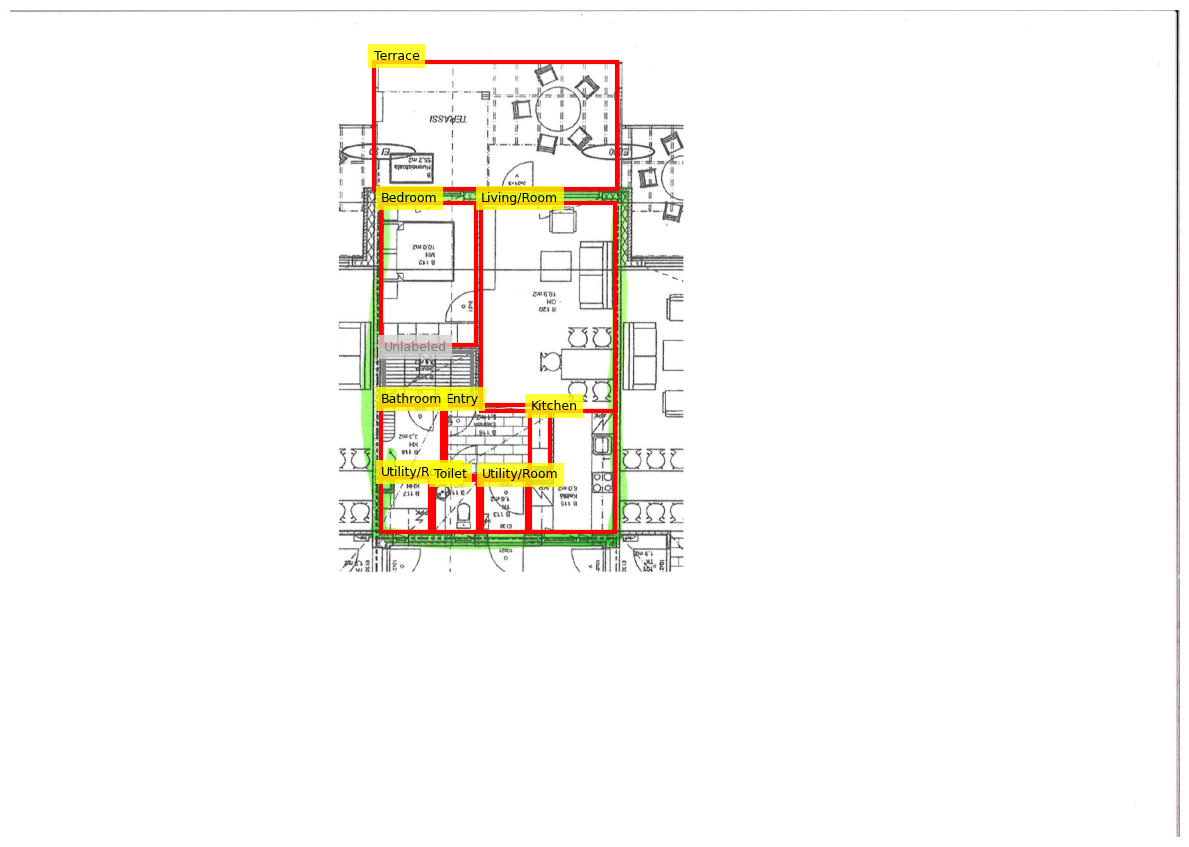

In [12]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load annotations
with open("annotations/train_annotations.json") as f:
    coco = json.load(f)

# Build image and category lookup
image_lookup = {img["id"]: img for img in coco["images"]}
category_lookup = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Visualize one image
def visualize_image(image_id, base_dir):
    img_info = image_lookup[image_id]
    img_path = os.path.join("/content/cubicasa_dataset/cubicasa5k", img_info["file_name"])

    if not os.path.exists(img_path):
        print(f" Image not found: {img_path}")
        return

    image = Image.open(img_path)
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(image)

    for ann in coco["annotations"]:
        if ann["image_id"] != image_id:
            continue

        x, y, w, h = ann["bbox"]
        label = category_lookup.get(ann["category_id"], "Unlabeled")

        # Thicker box lines
        edge_color = 'red' if label != "Unlabeled" else 'gray'
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=edge_color, facecolor='none')
        ax.add_patch(rect)

        #  Label background
        text_color = 'black' if label != "Unlabeled" else 'gray'
        bg_color = 'yellow' if label != "Unlabeled" else 'lightgray'
        ax.text(x, y - 5, label,
                fontsize=9,
                color=text_color,
                bbox=dict(facecolor=bg_color, alpha=0.8, edgecolor='none'))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
if coco["images"]:
    first_image_id = coco["images"][0]["id"]
    visualize_image(first_image_id, "/content/cubicasa_dataset/cubicasa5k")
else:
    print("No images found in the annotations.")

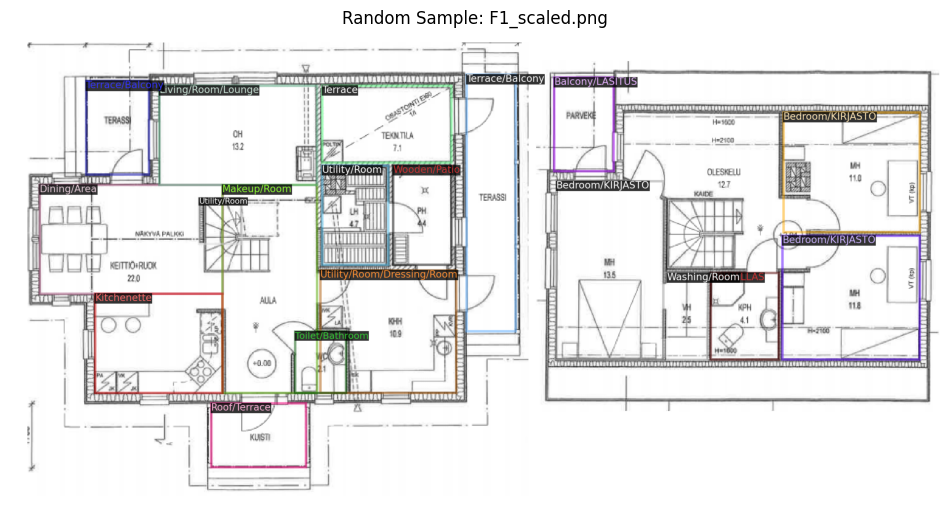

In [13]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, Metadata # Import Metadata
from detectron2.data.datasets import load_coco_json # Import load_coco_json

# Choose your dataset annotation file
annotation_file = "annotations/train_annotations.json" # Or "annotations/test_annotations.json" or "annotations/val_annotations.json"

# Load dataset dictionaries directly
try:
    dataset_dicts = load_coco_json(annotation_file, "/content/")
except FileNotFoundError:
    print(f"Error: Annotation file not found at {annotation_file}")
    dataset_dicts = [] # Set to empty list to prevent further errors

if dataset_dicts:
    # Create metadata manually
    # Ensure category_map is available globally from ZU6U7nelTH2c
    if 'category_map' not in globals():
        print("Error: category_map not found. Please run the data processing cell (ZU6U7nelTH2c) first.")
        metadata = Metadata() # Create empty metadata to prevent errors
    else:
        metadata = Metadata()
        metadata.thing_classes = list(category_map.keys()) # Set thing_classes from category_map
        # You might also want to set other metadata attributes like thing_colors if available
        # metadata.thing_colors = [...]


    # Pick a random sample
    sample = random.choice(dataset_dicts)

    # Construct the full image path from the file_name in the dataset dict
    img_path = sample["file_name"]


    # Load image safely
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Image not found or unreadable: {img_path}")
    else:
        # Ensure image is in BGR format for Visualizer
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert from RGB (Pillow default) to BGR (OpenCV default) if necessary, assuming image is read as RGB by default

        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0) # Pass manual metadata
        vis = visualizer.draw_dataset_dict(sample)

        plt.figure(figsize=(12, 12))
        plt.imshow(vis.get_image())
        plt.axis('off')
        plt.title(f"Random Sample: {os.path.basename(img_path)}")
        plt.show()
else:
    print("No dataset dictionaries loaded for visualization.")

In [32]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import os

# 🔧 Create config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# 🔹 Dataset registration (assumes already done)
cfg.DATASETS.TRAIN = ("cubicasa_train",)
cfg.DATASETS.TEST = ("cubicasa_val",)

# 🔹 Set number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(category_map)

# 🔹 Training hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.SOLVER.CHECKPOINT_PERIOD = 500  # Save every 500 iterations

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = "cpu"  # Use "cuda" if GPU is available

# 🔹 Load pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# 🔹 Output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/cubicasa_checkpoints/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# 🔹 Start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/13 08:38:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

AssertionError: Attribute 'thing_classes' in the metadata of 'cubicasa_train' cannot be set to a different value!
['AIDATTUA/PUUTARHAA', 'Alcove', 'Attic', 'Auxiliary/Kitchen', 'Balcony', 'Balcony/LASITUS', 'Bar/Area', 'Bathroom', 'Bathroom/Utility/Room', 'Bedroom', 'Bedroom/KIRJASTO', 'Carport', 'Ceiling/Height/Room', 'Closet/Storage', 'Commercial/Space', 'Corridor', 'Dining', 'Dining/Area', 'Dressing/Room', 'Entry', 'Fireplace', 'Fireplace/Technical/Room', 'Garage', 'Generic/Room', 'Glazed/Balcony', 'Glazed/Balcony/Terrace', 'Glazed/Porch', 'Hobby/Room', 'Hobby/Space', 'Home/Theater', 'Indoor/Storage', 'KORKEA/TILA', 'KPH', 'KPH/ALLAS', 'KPH/ARKIOLOH', 'KPH/ASK.H', 'KPH/AVOTERASSI', 'KPH/Bar/Area', 'KPH/Dining/Area/Bedroom', 'KPH/ETEISAULA', 'KPH/Glazed/Balcony/Terrace/Balcony', 'KPH/Glazed/Balcony/Terrace/Terrace', 'KPH/HALLI', 'KPH/HISSI', 'KPH/KATETTU/Terrace', 'KPH/KELLARI', 'KPH/KELLARI/ARKIOLOH', 'KPH/KELLARI/ASK', 'KPH/KELLARI/ASK.H', 'KPH/KELLARI/HALLI', 'KPH/KELLARI/KATETTU/Terrace', 'KPH/KELLARI/KYLMÄ/Attic', 'KPH/KELLARI/Office/Room', 'KPH/KELLARI/PANNUH', 'KPH/KELLARI/POLTTOAIH', 'KPH/KELLARI/PUKUH', 'KPH/KELLARI/PUUSEPÄN/VERSTAS', 'KPH/KELLARI/PUUVAJA', 'KPH/KELLARI/SALI', 'KPH/KELLARI/Storage/Walk/in/Closet', 'KPH/KELLARI/TALOUS', 'KPH/KELLARI/Unlabeled', 'KPH/KELLARI/VIERASHUONE', 'KPH/KELLARI/ÖLJY', 'KPH/KOMERO', 'KPH/KUIVAUSH', 'KPH/Kitchen/Dining', 'KPH/Kitchen/Dining/Area', 'KPH/MATALA/Storage', 'KPH/Outdoor/Storage', 'KPH/PARV.', 'KPH/PARVI', 'KPH/PATIO', 'KPH/PIHA', 'KPH/PIHA/Terrace', 'KPH/PYYKKI/Generic/Room', 'KPH/PYÖRÄT', 'KPH/SALI', 'KPH/SISÄPIHA', 'KPH/Storage/KYLMÄ', 'KPH/Storage/Technical/Room', 'KPH/TAKKA.H', 'KPH/TALOUS', 'KPH/TERASSIPIHA', 'KPH/TKH', 'KPH/TUPA', 'KPH/TUPA/PARVI', 'KPH/TUPAK', 'KPH/TV/Generic/Room', 'KPH/Technical/Room/Storage', 'KPH/Toilet/Utility/Room', 'KPH/UIMA/ALLAS', 'KPH/ULKOVARASTO', 'KPH/Unlabeled', 'KPH/Utility/Room', 'KPH/VERANTA', 'KPH/VIERASHUONE', 'KPH/ÖLJY', 'KYLMÄ/VAR.', 'KYLMÄ/VARASTOTILA', 'Kitchen', 'Kitchenette', 'LAS./Balcony', 'LASI/Balcony', 'LASI/PARV', 'Laundry/Room', 'Laundry/Washing/Room', 'Living/Room', 'Living/Room/Lounge', 'Lobby', 'Makeup/Room', 'Mirror/Cabinet', 'NURMI/PIHAA', 'Office', 'Office/Room', 'Open/Kitchen', 'Outdoor/Space', 'Outdoor/Storage', 'PUUSEPÄN/VERSTAS', 'Porch', 'Roof/Terrace', 'SPACEFORAPPLIANCE', 'SPACEFORAPPLIANCE2', 'Sauna', 'Shelter/Shed', 'Shower', 'Shower/Room', 'Steam/Room', 'Storage', 'TYÖ/JA/VIERASH', 'TYÖH/VERSTAT', 'Technical/Room', 'Terrace', 'Terrace/Balcony', 'Toilet', 'Toilet/Bathroom', 'Toilet/Washing/Room', 'Unlabeled', 'Utility/Room', 'Utility/Room/Dressing/Room', 'Walk/in/Closet', 'Washing/Room', 'Wooden/Patio', 'ÖLJY/POLTIN'] != ['AIDATTUA/PUUTARHAA', 'Alcove', 'Attic', 'Auxiliary/Kitchen', 'Balcony', 'Balcony/LASITUS', 'Bar/Area', 'Bathroom', 'Bathroom/Utility/Room', 'Bedroom', 'Bedroom/KIRJASTO', 'Carport', 'Ceiling/Height/Room', 'Closet/Storage', 'Commercial/Space', 'Corridor', 'Dining', 'Dining/Area', 'Dressing/Room', 'Entry', 'Fireplace', 'Fireplace/Technical/Room', 'Garage', 'Generic/Room', 'Glazed/Balcony', 'Glazed/Balcony/Terrace', 'Glazed/Porch', 'Hobby/Room', 'Hobby/Space', 'Home/Theater', 'Indoor/Storage', 'KORKEA/TILA', 'KPH', 'KPH/Toilet/Utility/Room', 'KPH/Utility/Room', 'KYLMÄ/VAR.', 'KYLMÄ/VARASTOTILA', 'Kitchen', 'Kitchenette', 'LAS./Balcony', 'LASI/Balcony', 'LASI/PARV', 'Laundry/Room', 'Laundry/Washing/Room', 'Living/Room', 'Living/Room/Lounge', 'Lobby', 'Makeup/Room', 'Mirror/Cabinet', 'NURMI/PIHAA', 'Office', 'Office/Room', 'Open/Kitchen', 'Outdoor/Space', 'Outdoor/Storage', 'PUUSEPÄN/VERSTAS', 'Porch', 'Roof/Terrace', 'SPACEFORAPPLIANCE', 'SPACEFORAPPLIANCE2', 'Sauna', 'Shelter/Shed', 'Shower', 'Shower/Room', 'Steam/Room', 'Storage', 'TYÖ/JA/VIERASH', 'TYÖH/VERSTAT', 'Technical/Room', 'Terrace', 'Terrace/Balcony', 'Toilet', 'Toilet/Bathroom', 'Toilet/Washing/Room', 'Unlabeled', 'Utility/Room', 'Utility/Room/Dressing/Room', 'Walk/in/Closet', 'Washing/Room', 'Wooden/Patio', 'ÖLJY/POLTIN']